In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
test = pd.read_csv('./Datasets/test.csv')
train = pd.read_csv('./Datasets/train.csv')

In [3]:
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.00,65.00,2020-01-22,0.00,0.00
1,2,NaN,Afghanistan,33.00,65.00,2020-01-23,0.00,0.00
2,3,NaN,Afghanistan,33.00,65.00,2020-01-24,0.00,0.00
3,4,NaN,Afghanistan,33.00,65.00,2020-01-25,0.00,0.00
4,5,NaN,Afghanistan,33.00,65.00,2020-01-26,0.00,0.00


In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,17040.00,13190.00,7624.68,1.00,6595.50,13190.00,19784.50,26379.00
Lat,17040.00,26.29,22.94,-41.45,13.15,32.99,42.50,71.71
Long,17040.00,4.77,79.92,-157.50,-71.52,9.78,64.69,174.89
ConfirmedCases,17040.00,285.09,3318.44,0.00,0.00,0.00,9.00,67800.00
Fatalities,17040.00,9.83,148.01,0.00,0.00,0.00,0.00,4825.00


In [5]:
train.isnull().sum()

Id                   0
Province/State    9240
Country/Region       0
Lat                  0
Long                 0
Date                 0
ConfirmedCases       0
Fatalities           0
dtype: int64

In [6]:
train['Province/State'].fillna(train['Country/Region'], inplace=True)

In [7]:
train.isnull().sum()

Id                0
Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64

In [8]:
train.nunique()

Id                17040
Province/State      274
Country/Region      163
Lat                 272
Long                276
Date                 60
ConfirmedCases      909
Fatalities          165
dtype: int64

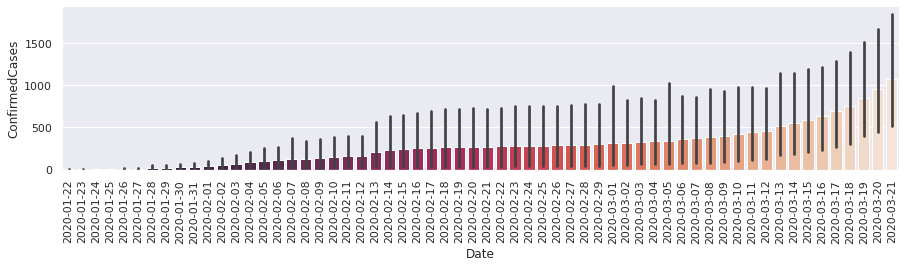

In [9]:
plt.figure(figsize=(15,3))
sns.barplot(x=train['Date'],
            y=train['ConfirmedCases'],
            palette="rocket")
plt.xticks(rotation=90)
plt.show()

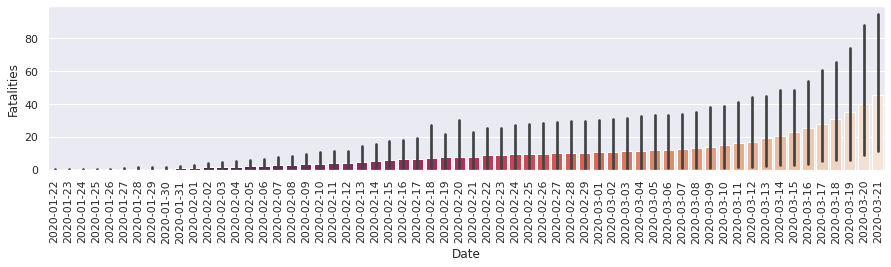

In [10]:
plt.figure(figsize=(15,3))
sns.barplot(x=train['Date'],
            y=train['Fatalities'],
            palette="rocket")
plt.xticks(rotation=90)
plt.show()

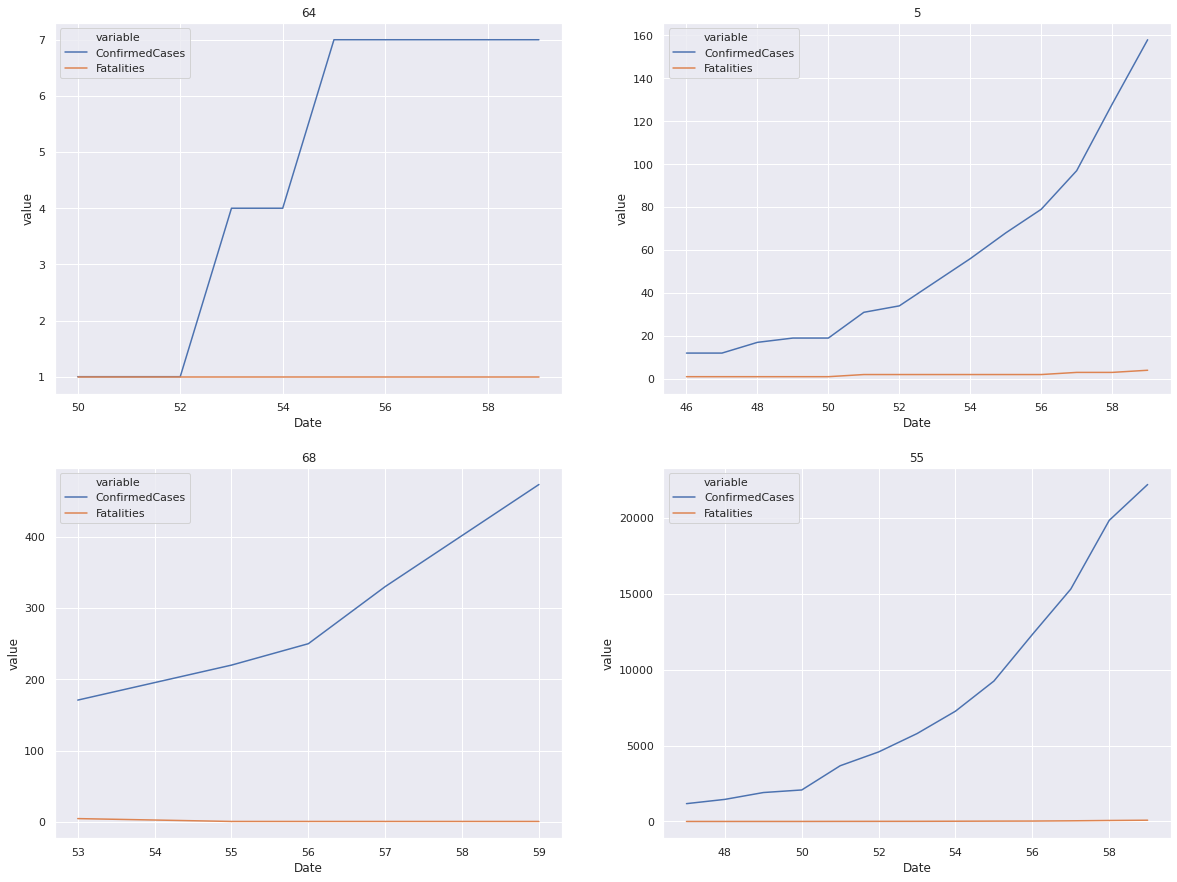

In [45]:
train_fatalities = train.loc[train['Fatalities'] > 0]
fig, ax = plt.subplots(2, 2, figsize=(20,15))
for i in range(0, 4):
    country = train_fatalities['Country/Region'].unique()[np.random.randint(i,50)]
    country_data = train_fatalities.loc[train_fatalities['Country/Region']==country]
    sns.lineplot(x='Date',
                 y='value',
                 hue='variable',
                 data=pd.melt(country_data[['ConfirmedCases', 'Fatalities', 'Date']], ['Date']),
                 ax=ax[int(i/2)][i%2]).set_title(country)
plt.show()

In [12]:
import math

hubei_lat = train.loc[(train['Country/Region'] == 'China') & (train['Province/State'] == 'Hubei')].iloc[0]['Lat']
hubei_long = train.loc[(train['Country/Region'] == 'China') & (train['Province/State'] == 'Hubei')].iloc[0]['Long']

def dist_from_hubei(row):
    return math.sqrt(math.pow(row['Lat'] - hubei_lat, 2) + math.pow(row['Long'] - hubei_long, 2))

train['dist_from_hubei'] = train.apply(dist_from_hubei, axis=1)
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,dist_from_hubei
0,1,Afghanistan,Afghanistan,33.00,65.00,2020-01-22,0.00,0.00,47.31
1,2,Afghanistan,Afghanistan,33.00,65.00,2020-01-23,0.00,0.00,47.31
2,3,Afghanistan,Afghanistan,33.00,65.00,2020-01-24,0.00,0.00,47.31
3,4,Afghanistan,Afghanistan,33.00,65.00,2020-01-25,0.00,0.00,47.31
4,5,Afghanistan,Afghanistan,33.00,65.00,2020-01-26,0.00,0.00,47.31


In [13]:
train_from_hubei = train.loc[(train['Province/State'] != 'Hubei')]\
.groupby(['dist_from_hubei'])\
.agg({
    'Fatalities': ['sum'],
    'ConfirmedCases': ['sum']
})

train_from_hubei.reset_index(inplace=True)
train_from_hubei.columns = ['dist_from_hubei', 'total_fatalities', 'total_confirmed']

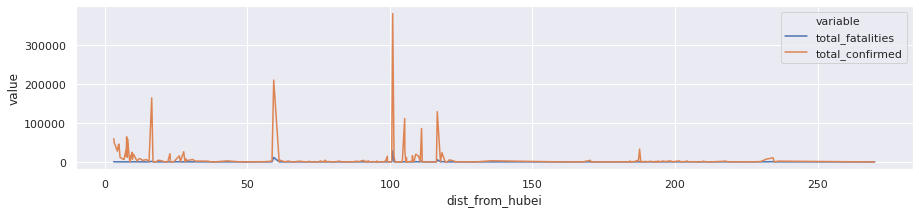

In [14]:
plt.figure(figsize=(15,3))
sns.lineplot(x='dist_from_hubei',
             y='value',
             hue='variable',
             data=pd.melt(
                 train_from_hubei[['total_fatalities', 'total_confirmed', 'dist_from_hubei']], 
                 ['dist_from_hubei'])
            )

In [15]:
lag_list = [1, 2, 3, 7]

for lag in lag_list:
    train[f'confirmed_shifted_{lag}'] = train.sort_values(
                                            ['Country/Region', 
                                             'Province/State',
                                             'Date']
                                        )['ConfirmedCases']\
                                        .shift(lag)
    train[f'confirmed_shifted_{lag}'].fillna(0, inplace=True)
    train[f'fatalities_shifted_{lag}'] = train.sort_values(
                                            ['Country/Region', 
                                             'Province/State',
                                             'Date']
                                        )['Fatalities']\
                                        .shift(lag)
    train[f'fatalities_shifted_{lag}'].fillna(0, inplace=True)

In [16]:
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,dist_from_hubei,confirmed_shifted_1,fatalities_shifted_1,confirmed_shifted_2,fatalities_shifted_2,confirmed_shifted_3,fatalities_shifted_3,confirmed_shifted_7,fatalities_shifted_7
0,1,Afghanistan,Afghanistan,33.00,65.00,2020-01-22,0.00,0.00,47.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,Afghanistan,Afghanistan,33.00,65.00,2020-01-23,0.00,0.00,47.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,Afghanistan,Afghanistan,33.00,65.00,2020-01-24,0.00,0.00,47.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,4,Afghanistan,Afghanistan,33.00,65.00,2020-01-25,0.00,0.00,47.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,Afghanistan,Afghanistan,33.00,65.00,2020-01-26,0.00,0.00,47.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [17]:
from sklearn.preprocessing import LabelEncoder
state_encoder = LabelEncoder().fit(train['Province/State'])
train['Province/State'] = state_encoder.transform(train['Province/State'])
country_encoder = LabelEncoder().fit(train['Country/Region'])
train['Country/Region'] = country_encoder.transform(train['Country/Region'])
date_encoder = LabelEncoder().fit(train['Date'])
train['Date'] = date_encoder.transform(train['Date'])

In [30]:
train_data = train.loc[train['Date'] < 50]
X_train = train.drop(['ConfirmedCases', 'Fatalities'], axis=1)
y1_train = train['ConfirmedCases']
y2_train = train['Fatalities']
validation_data = train.loc[train['Date'] >= 50]
X_validation = validation_data.drop(['ConfirmedCases', 'Fatalities'], axis=1)
y1_validation = validation_data['ConfirmedCases']
y2_validation = validation_data['Fatalities']

In [43]:
from catboost import Pool
from catboost import CatBoostRegressor

confirmed_cases_model = CatBoostRegressor(
    iterations=20000,
    learning_rate=0.5,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=8
)

confirmed_cases_model.fit(
    X_train, y1_train,
    eval_set=(X_validation, y1_validation)
)

0:	learn: 1974.7873787	test: 2928.1216404	best: 2928.1216404 (0)	total: 20.3ms	remaining: 6m 45s
50:	learn: 52.3734127	test: 84.1805989	best: 84.1805989 (50)	total: 826ms	remaining: 5m 23s
100:	learn: 22.2964525	test: 35.7567503	best: 35.7567503 (100)	total: 1.62s	remaining: 5m 19s
150:	learn: 13.7512838	test: 21.6681884	best: 21.6681884 (150)	total: 2.17s	remaining: 4m 45s
200:	learn: 9.8280697	test: 14.9709016	best: 14.9709016 (200)	total: 3.26s	remaining: 5m 21s
250:	learn: 7.4146105	test: 11.3276239	best: 11.3276239 (250)	total: 3.86s	remaining: 5m 3s
300:	learn: 6.1015500	test: 9.1590346	best: 9.1590346 (300)	total: 4.37s	remaining: 4m 46s
350:	learn: 5.1204632	test: 7.7331266	best: 7.7331266 (350)	total: 4.84s	remaining: 4m 31s
400:	learn: 4.3665543	test: 6.5790323	best: 6.5790323 (400)	total: 5.35s	remaining: 4m 21s
450:	learn: 3.7788589	test: 5.6001160	best: 5.6001160 (450)	total: 5.94s	remaining: 4m 17s
500:	learn: 3.2864894	test: 4.9725590	best: 4.9725590 (500)	total: 6.58s	r

4450:	learn: 0.0854570	test: 0.0828942	best: 0.0828942 (4450)	total: 1m 6s	remaining: 3m 52s
4500:	learn: 0.0833697	test: 0.0797068	best: 0.0797068 (4500)	total: 1m 7s	remaining: 3m 50s
4550:	learn: 0.0814626	test: 0.0760472	best: 0.0760472 (4550)	total: 1m 7s	remaining: 3m 49s
4600:	learn: 0.0788668	test: 0.0743923	best: 0.0743906 (4599)	total: 1m 8s	remaining: 3m 48s
4650:	learn: 0.0766618	test: 0.0718932	best: 0.0718932 (4650)	total: 1m 8s	remaining: 3m 47s
4700:	learn: 0.0748945	test: 0.0709892	best: 0.0709866 (4699)	total: 1m 9s	remaining: 3m 47s
4750:	learn: 0.0732657	test: 0.0698665	best: 0.0698665 (4750)	total: 1m 10s	remaining: 3m 47s
4800:	learn: 0.0713851	test: 0.0673162	best: 0.0673162 (4800)	total: 1m 11s	remaining: 3m 46s
4850:	learn: 0.0696402	test: 0.0652100	best: 0.0652081 (4849)	total: 1m 12s	remaining: 3m 47s
4900:	learn: 0.0681756	test: 0.0629511	best: 0.0629511 (4900)	total: 1m 13s	remaining: 3m 45s
4950:	learn: 0.0668938	test: 0.0614054	best: 0.0614054 (4950)	tota

8850:	learn: 0.0141215	test: 0.0091756	best: 0.0091750 (8847)	total: 2m 13s	remaining: 2m 47s
8900:	learn: 0.0138926	test: 0.0090072	best: 0.0090072 (8900)	total: 2m 14s	remaining: 2m 48s
8950:	learn: 0.0136696	test: 0.0087986	best: 0.0087986 (8950)	total: 2m 15s	remaining: 2m 47s
9000:	learn: 0.0134064	test: 0.0086209	best: 0.0086198 (8996)	total: 2m 18s	remaining: 2m 48s
9050:	learn: 0.0131710	test: 0.0084501	best: 0.0084500 (9049)	total: 2m 20s	remaining: 2m 49s
9100:	learn: 0.0129313	test: 0.0082038	best: 0.0082038 (9100)	total: 2m 21s	remaining: 2m 49s
9150:	learn: 0.0127130	test: 0.0081065	best: 0.0081065 (9150)	total: 2m 22s	remaining: 2m 48s
9200:	learn: 0.0125357	test: 0.0078996	best: 0.0078996 (9197)	total: 2m 23s	remaining: 2m 47s
9250:	learn: 0.0123599	test: 0.0077245	best: 0.0077242 (9245)	total: 2m 23s	remaining: 2m 46s
9300:	learn: 0.0121549	test: 0.0075746	best: 0.0075746 (9300)	total: 2m 24s	remaining: 2m 45s
9350:	learn: 0.0119581	test: 0.0073983	best: 0.0073983 (9350

In [44]:
fatalities_cases_model = CatBoostRegressor(
    iterations=20000,
    learning_rate=0.5,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=8
)

fatalities_cases_model.fit(
    X_train, y2_train,
    eval_set=(X_validation, y2_validation)
)

0:	learn: 86.8416292	test: 158.6017862	best: 158.6017862 (0)	total: 11.2ms	remaining: 3m 44s
50:	learn: 2.2521969	test: 3.3648967	best: 3.3648967 (50)	total: 470ms	remaining: 3m 4s
100:	learn: 0.8882343	test: 1.3529095	best: 1.3529095 (100)	total: 986ms	remaining: 3m 14s
150:	learn: 0.4966983	test: 0.7390297	best: 0.7390297 (150)	total: 1.44s	remaining: 3m 9s
200:	learn: 0.3405963	test: 0.5193642	best: 0.5193642 (200)	total: 1.88s	remaining: 3m 4s
250:	learn: 0.2521058	test: 0.3836369	best: 0.3836369 (250)	total: 2.38s	remaining: 3m 7s
300:	learn: 0.1892243	test: 0.3063417	best: 0.3063417 (300)	total: 2.84s	remaining: 3m 6s
350:	learn: 0.1546422	test: 0.2420741	best: 0.2420741 (350)	total: 3.31s	remaining: 3m 5s
400:	learn: 0.1330842	test: 0.2085703	best: 0.2085703 (400)	total: 3.85s	remaining: 3m 7s
450:	learn: 0.1125162	test: 0.1749298	best: 0.1749298 (450)	total: 4.33s	remaining: 3m 7s
500:	learn: 0.0985532	test: 0.1483155	best: 0.1483155 (500)	total: 4.79s	remaining: 3m 6s
550:	lea

4500:	learn: 0.0017846	test: 0.0020472	best: 0.0020472 (4500)	total: 49.1s	remaining: 2m 49s
4550:	learn: 0.0017305	test: 0.0019940	best: 0.0019940 (4550)	total: 49.6s	remaining: 2m 48s
4600:	learn: 0.0016848	test: 0.0019248	best: 0.0019248 (4600)	total: 50.2s	remaining: 2m 47s
4650:	learn: 0.0016390	test: 0.0018706	best: 0.0018706 (4650)	total: 50.7s	remaining: 2m 47s
4700:	learn: 0.0015981	test: 0.0018171	best: 0.0018171 (4700)	total: 51.4s	remaining: 2m 47s
4750:	learn: 0.0015494	test: 0.0017520	best: 0.0017520 (4749)	total: 51.9s	remaining: 2m 46s
4800:	learn: 0.0015063	test: 0.0016915	best: 0.0016915 (4800)	total: 52.6s	remaining: 2m 46s
4850:	learn: 0.0014704	test: 0.0016611	best: 0.0016611 (4850)	total: 53.3s	remaining: 2m 46s
4900:	learn: 0.0014313	test: 0.0016078	best: 0.0016078 (4900)	total: 53.8s	remaining: 2m 45s
4950:	learn: 0.0013912	test: 0.0015399	best: 0.0015399 (4950)	total: 54.3s	remaining: 2m 45s
5000:	learn: 0.0013609	test: 0.0014973	best: 0.0014973 (5000)	total: 5

8900:	learn: 0.0002817	test: 0.0002002	best: 0.0002002 (8900)	total: 1m 37s	remaining: 2m 1s
8950:	learn: 0.0002777	test: 0.0001950	best: 0.0001950 (8950)	total: 1m 37s	remaining: 2m
9000:	learn: 0.0002723	test: 0.0001921	best: 0.0001921 (8999)	total: 1m 38s	remaining: 1m 59s
9050:	learn: 0.0002679	test: 0.0001879	best: 0.0001879 (9050)	total: 1m 38s	remaining: 1m 59s
9100:	learn: 0.0002628	test: 0.0001861	best: 0.0001861 (9097)	total: 1m 39s	remaining: 1m 59s
9150:	learn: 0.0002591	test: 0.0001830	best: 0.0001830 (9150)	total: 1m 39s	remaining: 1m 58s
9200:	learn: 0.0002547	test: 0.0001810	best: 0.0001810 (9199)	total: 1m 40s	remaining: 1m 57s
9250:	learn: 0.0002506	test: 0.0001782	best: 0.0001782 (9250)	total: 1m 40s	remaining: 1m 57s
9300:	learn: 0.0002459	test: 0.0001741	best: 0.0001741 (9300)	total: 1m 41s	remaining: 1m 56s
9350:	learn: 0.0002426	test: 0.0001706	best: 0.0001706 (9350)	total: 1m 41s	remaining: 1m 55s
9400:	learn: 0.0002389	test: 0.0001670	best: 0.0001670 (9400)	tot

13250:	learn: 0.0000761	test: 0.0000332	best: 0.0000332 (13234)	total: 2m 29s	remaining: 1m 16s
13300:	learn: 0.0000747	test: 0.0000324	best: 0.0000324 (13300)	total: 2m 29s	remaining: 1m 15s
13350:	learn: 0.0000735	test: 0.0000321	best: 0.0000321 (13350)	total: 2m 30s	remaining: 1m 15s
13400:	learn: 0.0000724	test: 0.0000319	best: 0.0000319 (13398)	total: 2m 31s	remaining: 1m 14s
13450:	learn: 0.0000714	test: 0.0000314	best: 0.0000314 (13449)	total: 2m 31s	remaining: 1m 13s
13500:	learn: 0.0000703	test: 0.0000310	best: 0.0000309 (13496)	total: 2m 32s	remaining: 1m 13s
13550:	learn: 0.0000694	test: 0.0000303	best: 0.0000303 (13549)	total: 2m 33s	remaining: 1m 12s
13600:	learn: 0.0000683	test: 0.0000298	best: 0.0000298 (13599)	total: 2m 33s	remaining: 1m 12s
13650:	learn: 0.0000675	test: 0.0000291	best: 0.0000291 (13649)	total: 2m 34s	remaining: 1m 11s
13700:	learn: 0.0000666	test: 0.0000286	best: 0.0000286 (13700)	total: 2m 34s	remaining: 1m 11s
13750:	learn: 0.0000657	test: 0.0000283	

17600:	learn: 0.0000228	test: 0.0000082	best: 0.0000082 (17593)	total: 3m 22s	remaining: 27.6s
17650:	learn: 0.0000225	test: 0.0000081	best: 0.0000081 (17650)	total: 3m 23s	remaining: 27.1s
17700:	learn: 0.0000223	test: 0.0000081	best: 0.0000081 (17700)	total: 3m 24s	remaining: 26.5s
17750:	learn: 0.0000220	test: 0.0000079	best: 0.0000079 (17748)	total: 3m 24s	remaining: 26s
17800:	learn: 0.0000217	test: 0.0000078	best: 0.0000078 (17800)	total: 3m 26s	remaining: 25.4s
17850:	learn: 0.0000215	test: 0.0000077	best: 0.0000077 (17850)	total: 3m 26s	remaining: 24.9s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 7.648145015e-06
bestIteration = 17870

Shrink model to first 17871 iterations.


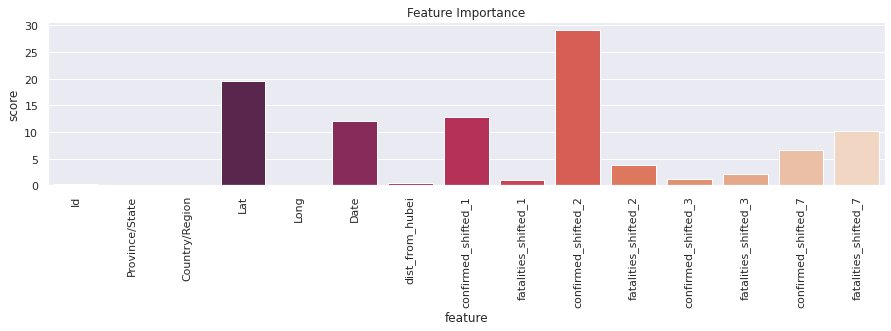

In [48]:
confirmed_cases_score = pd.DataFrame(confirmed_cases_model.get_feature_importance(
    Pool(X_train, label=y1_train)), columns=['score'])
confirmed_cases_score['feature'] = X_train.columns

plt.figure(figsize=(15,3))
sns.barplot(x='feature', y='score', data=confirmed_cases_score, palette="rocket").set_title("Feature Importance")
plt.xticks(rotation=90)
plt.show()

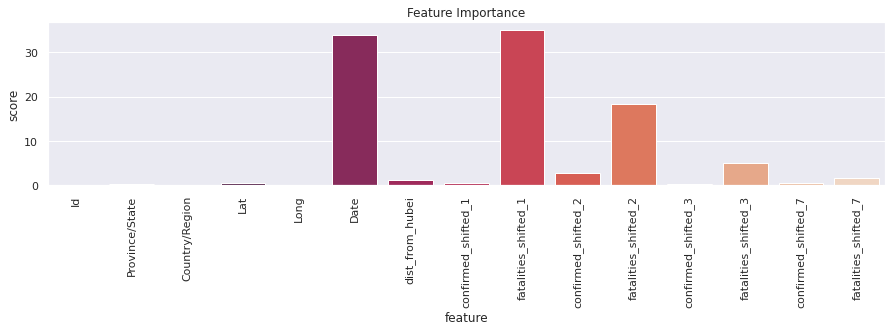

In [51]:
fatalities_score = pd.DataFrame(fatalities_cases_model.get_feature_importance(
    Pool(X_train, label=y2_train)), columns=['score'])
fatalities_score['feature'] = X_train.columns

plt.figure(figsize=(15,3))
sns.barplot(x='feature', y='score', data=fatalities_score, palette="rocket").set_title("Feature Importance")
plt.xticks(rotation=90)
plt.show()